In this lab, we are going to fit a straight line model to some data.  This goes by the name "linear regression",
and we are going to do this on our way to more complicated analyses next week.

Here is our data set:

In [24]:
y = [14., 26., 37., 43.]
sigma = [1., 1., 2., 2.]
x = [1., 2., 3., 4.];

In [25]:
using Plots

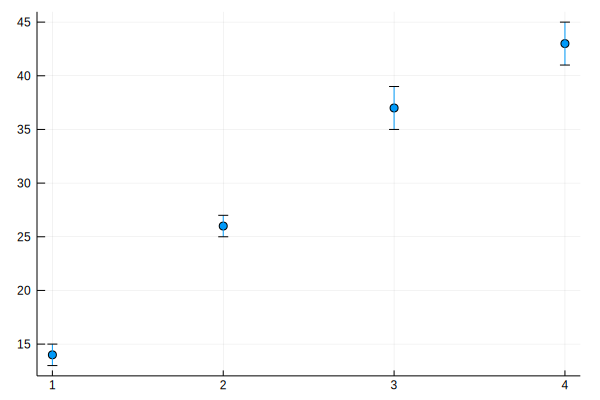

In [26]:
plot(x, y, seriestype=:scatter, yerr=sigma, legend=false)

This data set sure begs to have a line fit to it, right?

First, we'll set up the matrix equations:

In [27]:
Y = y

4-element Array{Float64,1}:
 14.0
 26.0
 37.0
 43.0

In [28]:
N = length(Y)
A = zeros(N,2)

4×2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

In [29]:
A[:,1] .= 1.;
A[:,2] .= x;

In [30]:
A

4×2 Array{Float64,2}:
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0

Now we can use Julia's built-in "\" (right-division) operator to do a least-squares solve:

In [41]:
MB1 = A \ Y

2-element Array{Float64,1}:
 5.500000000000001
 9.799999999999999

But this doesn't make use of the uncertainties!  We need to include a "weight" matrix (it's diagonal in this case, because we assumed our measurement errors are independent):

In [38]:
using LinearAlgebra

In [39]:
W = Diagonal(1 ./ sigma.^2)

4×4 Diagonal{Float64,Array{Float64,1}}:
 1.0   ⋅    ⋅     ⋅  
  ⋅   1.0   ⋅     ⋅  
  ⋅    ⋅   0.25   ⋅  
  ⋅    ⋅    ⋅    0.25

Here's our weighted least-squares solution:

In [63]:
MB2 = (sqrt(W)*A) \ (sqrt(W)*Y)

2-element Array{Float64,1}:
  4.573033707865167
 10.224719101123595

Notice that it is slightly different than the unweighted version!

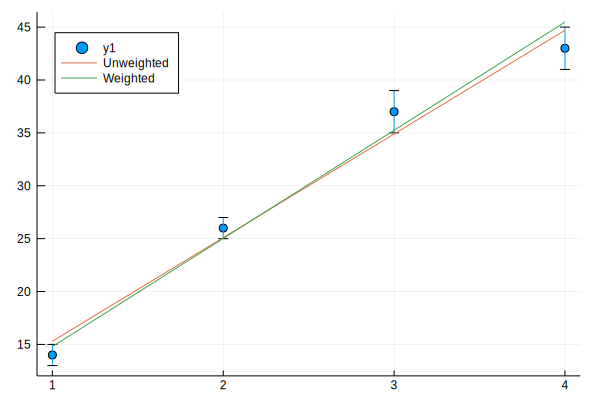

In [138]:
plot(x, y, seriestype=:scatter, yerr=sigma, legend=:topleft)
plot!(x, A * MB1, label="Unweighted")
plot!(x, A * MB2, label="Weighted")

Notice how the "weighted" version goes closer to hitting the left two data points, because their error bars are smaller (weights are larger).

We can also compute the variance/covariance matrix for the maximum-likelihood m and b values:

In [64]:
C = inv(A' * W * A)

2×2 Array{Float64,2}:
  2.02247   -0.853933
 -0.853933   0.449438

Given this, we can draw samples from the distribution of m and b that are consistent with our data:

In [86]:
r = randn((100,2));

In [68]:
s = sqrt(C)

2×2 Array{Float64,2}:
  1.34269   -0.468663
 -0.468663   0.479368

In [69]:
s * s

2×2 Array{Float64,2}:
  2.02247   -0.853933
 -0.853933   0.449438

In [88]:
dmb = r*s;

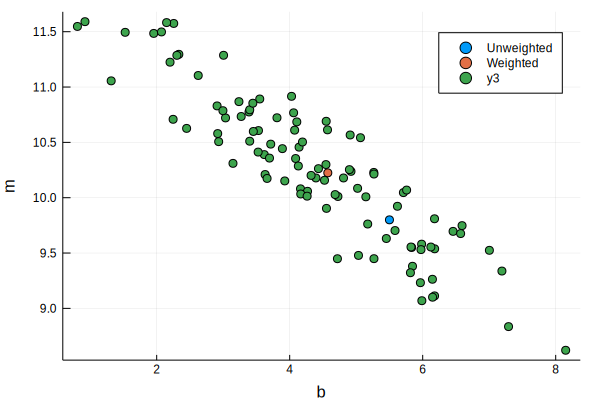

In [89]:
plot([MB1[1]], [MB1[2]], seriestype=:scatter, label="Unweighted",
            xlabel="b", ylabel="m")
plot!([MB2[1]], [MB2[2]], seriestype=:scatter, label="Weighted")
plot!(MB2[1] .+ dmb[:,1], MB2[2] .+ dmb[:,2], seriestype=:scatter)

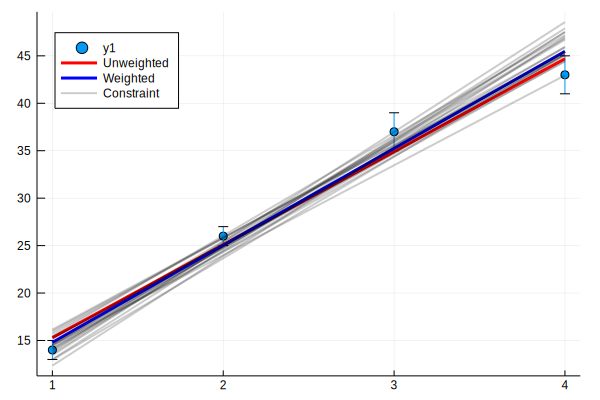

In [140]:
plot(x, y, seriestype=:scatter, yerr=sigma, legend=:topleft)
plot!(x, A * MB1, line=(:red, 1, 3), label="Unweighted")
plot!(x, A * MB2, line=(:blue, 1, 3), label="Weighted")
for i in 1:20
    plot!(x, A * (MB2 + dmb[i,:]), label=((i == 1) ? "Constraint" : ""), line=(:black, 0.2, 2))
end
plot!()

Now, just for kicks, let's instead fit a quadratic to this little data set.

In [141]:
A2 = zeros(N,3)
A2[:,1] .= 1.
A2[:,2] .= x
A2[:,3] .= x.^2;

In [142]:
Q = (sqrt(W) * A2) \ (sqrt(W) * Y)

3-element Array{Float64,1}:
 -0.9199999999999652
 16.099999999999973 
 -1.259999999999994 

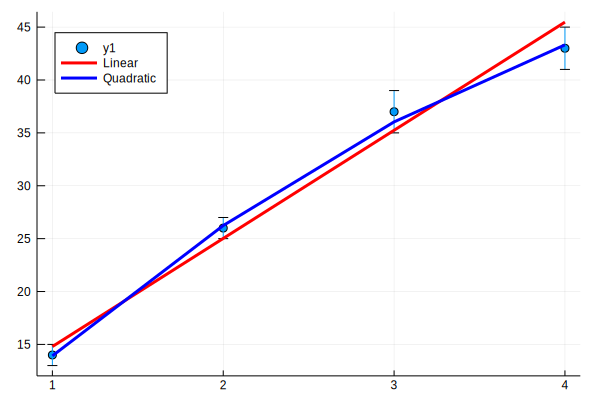

In [144]:
plot(x, y, seriestype=:scatter, yerr=sigma, legend=:topleft)
plot!(x, A * MB2, line=(:red, 1, 3), label="Linear")
plot!(x, A2 * Q, line=(:blue, 1, 3), label="Quadratic")    

In [147]:
function quadratic(Q)
    return x -> Q[1] .+ Q[2].*x .+ Q[3].*x.^2
end

quadratic (generic function with 1 method)

In [148]:
q = quadratic(Q)

#3 (generic function with 1 method)

In [155]:
q(2.7)

33.3646

In [151]:
function quadratic(Q)
    function q(x)
        return Q[1] .+ Q[2].*x .+ Q[3].*x.^2
    end
    return q
end

quadratic (generic function with 1 method)

In [152]:
q = quadratic(Q)

q (generic function with 1 method)

In [156]:
q(1)

13.920000000000014

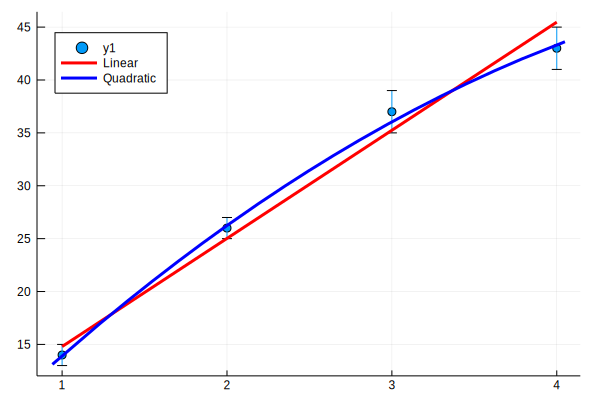

In [157]:
plot(x, y, seriestype=:scatter, yerr=sigma, legend=:topleft)
plot!(x, A * MB2, line=(:red, 1, 3), label="Linear")
plot!(q, line=(:blue, 1, 3), label="Quadratic")

Now, we're going to set linear algebra aside and switch to a probabilistic perspective.

We'll start by writing the log-likelihood function for our data given a straight-line model.

In [159]:
function line_log_likelihood(x, y, sigma, m, b)
    # We're only fitting m and b, so we're going to ignore the log-likelihood term involving the sigmas.
    chi_squared = sum((m .* x .+ b .- y).^2 ./ sigma.^2)
    return -0.5 * chi_squared
end

line_log_likelihood (generic function with 1 method)

In [160]:
line_log_likelihood(x, y, sigma, MB2[2], MB2[1])

-1.9438202247190999

Now we'll wrap this function in a function that knows about our data set x,y,sigma.

In [164]:
function line_lnl(bm)
    b,m = bm
    return line_log_likelihood(x, y, sigma, m, b)
end

line_lnl (generic function with 2 methods)

In [165]:
line_lnl(MB2)

-1.9438202247190999

Let's see what this likelihood space looks like.  Evaluate it on a grid of m and b values.

In [166]:
MB2

2-element Array{Float64,1}:
  4.573033707865167
 10.224719101123595

In [167]:
s

2×2 Array{Float64,2}:
  1.34269   -0.468663
 -0.468663   0.479368

In [171]:
blo = MB2[2] - 3 * s[2,2]
bhi = MB2[2] + 3 * s[2,2]
mlo = MB2[1] - 3 * s[1,1]
mhi = MB2[1] + 3 * s[1,1];

In [173]:
bb = range(blo, stop=bhi, length=100)
mm = range(mlo, stop=mhi, length=100)

0.5449518635039157:0.08137539079517679:8.601115552226418

In [175]:
LL = zeros((length(mm), length(bb)));
for i in 1:length(mm)
    for j in 1:length(bb)
        LL[i, j] = line_lnl(mm[i], bb[j])
    end
end

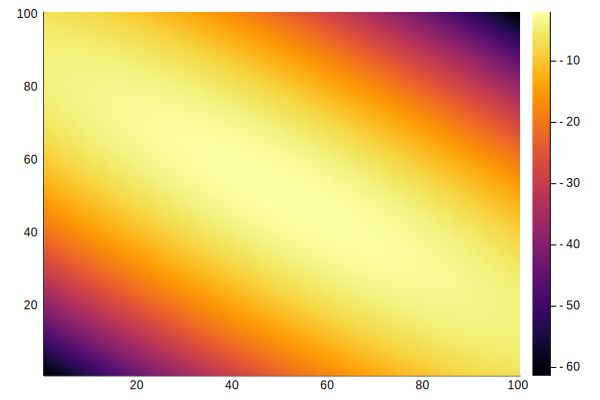

In [176]:
heatmap(LL)